# Two robots of the same type

The code for this example is implemented [same_robots](https://github.com/jeguzzi/enki_env/tree/main/enki_env/examples/same_robots). Let us import it.

In [1]:
from enki_env.examples import same_robots

## Environment

The environment contains just two Thymio robots. The initial position of the robots is fixed while their orientation is sampled uniformly.  
The robots' goal is to rotate so to face each other.

To create the environment via script, run:  
```console  
python -m enki_env.examples.same_robot.environment  
```

RFBOutputContext()


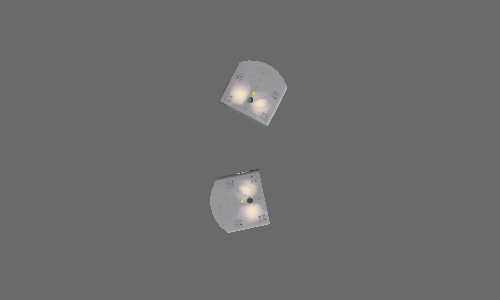

In [2]:
env = same_robots.make_env(render_mode="human")
env.reset()
env.snapshot()

The robots belong to the same ``"thymio"`` group and share the same configuration.

In [3]:
env.group_map

{'thymio': ['thymio_0', 'thymio_1']}

Like in the single robot example, the robots use just their proximity sensors and receive a similar reward that makes them want to rotate until they face each other, when the episode terminates.

In [4]:
env.action_spaces

{'thymio_0': Box(-1.0, 1.0, (1,), float64),
 'thymio_1': Box(-1.0, 1.0, (1,), float64)}

In [5]:
env.observation_spaces

{'thymio_0': Dict('wheel_speeds': Box(-1.0, 1.0, (2,), float64), 'prox/value': Box(0.0, 1.0, (7,), float64)),
 'thymio_1': Dict('wheel_speeds': Box(-1.0, 1.0, (2,), float64), 'prox/value': Box(0.0, 1.0, (7,), float64))}

## Baseline

We have hand-coded a simple distributed policy to achieve the task.

To evaluate the baseline via script, run:
```console
python -m enki_env.examples.same_robots.baseline
```

In [6]:
import inspect

print(inspect.getsource(same_robots.Baseline.predict))

    def predict(self,
                observation: Observation,
                state: State | None = None,
                episode_start: EpisodeStart | None = None,
                deterministic: bool = False) -> tuple[Action, State | None]:
        prox = np.atleast_2d(np.array(observation['prox/value']))
        m = np.max(prox, axis=-1)
        prox[m > 0] /= m[:, np.newaxis][m > 0]
        ws = np.array([(0.5, 0.25, 0, -0.25, -0.5, 1, 1)])
        w = np.tensordot(prox, ws, axes=([1], [1]))
        w[m == 0] = 1
        return np.clip(w, -1, 1), None



To perform a rollout, we need to assign the policy to the whole group.

In [7]:
rollout = env.unwrapped.rollout(max_steps=10, policies={'thymio': same_robots.Baseline()})

For multi-robot environments, the rollouts return a dictionary with data collected from each group,

In [8]:
rollout.keys()

dict_keys(['thymio'])

In [9]:
rollout['thymio'].episode_reward

np.float64(-22.821592696832248)

## Reinforcement Learning

Let us now train and evaluate a RL policy for the same task.

To perform this via script, run:
```console
python -m enki_env.examples.same_robots.rl

In [10]:
policy = same_robots.get_policy()

In [11]:
rollout = env.unwrapped.rollout(max_steps=10, policies={'thymio': policy})
rollout['thymio'].episode_reward

np.float64(-9.336332451263782)

## Video

To generate a similar video as in the single robot example, run

```console
python -m enki_env.examples.same_robots.video
```

or run

In [12]:
video = same_robots.make_video()
video.display_in_notebook(fps=30, width=640, rd_kwargs=dict(logger=None))